### Hyperparameters and Imports

In [1]:
# Import everything that is necessary
import argparse
from torch.utils.data.dataset import Dataset
import os
import math
import torch
from pathlib import Path
import cv2
import numpy as np
import torch.nn as nn
import timm
from torch.utils.data import DataLoader
from urllib.request import urlopen
from PIL import Image
import timm
from timm import create_model
from tqdm import tqdm
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt


c:\Users\USER\miniconda3\envs\revisedTransformer\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hyperparams = {
    # Network params
    'n_classes': 12,
    'pretrained': True,
    'n_head': 8,
    'dropout_backbone': 0.1,  # dropout2d
    'dropout_transformer': 0.5,  # dropout1d
    'dff': 1024,  # ff_size
    'n_module': 6,
    
    # Solver params (required by ModuleUtilizer)
    'solver': {
        'type': 'AdamW',  # or 'Adam', 'SGD', 'RMSProp'
        'base_lr': 0.0001,
        'weight_decay': 0.0001,
        'momentum': 0.9,  # only used for SGD
        'lr_policy': 'fixed',  # or 'step', 'multistep', 'exp', 'inv'
        'gamma': 0.1,
        'stepvalue': [50, 75]  # for multistep policy
    },
    
    # Checkpoint params (required by ModuleUtilizer)
    'checkpoints': {
        'save_policy': 'best',  # or 'all', 'early_stop'
        'save_name': 'gesture_model',
        'save_dir': './checkpoints/',
        'early_stop': 10  # patience for early stopping
    },
    
    # Other required params
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dataset': 'Briareo',
    'gpu': [0],  # GPU IDs for DataParallel
    'resume': None  # Path to checkpoint to resume from, or None
}

# Decide if we use timm_backbone or not
timm_backbone = True
model_name = "resnet18.a1_in1k"

In [3]:
import torch;
print(torch.__version__)
print(torch.cuda.is_available())


2.10.0+cu128
True


### Data Loading

In [4]:
class Briareo(Dataset):
    """Briareo Dataset class"""
    def __init__(self, configer, path, split="train", data_type='depth', transforms=None, n_frames=30, optical_flow=False):
        """Constructor method for Briareo Dataset class

        Args:
            configer (Configer): Configer object for current procedure phase (train, test, val)
            split (str, optional): Current procedure phase (train, test, val)
            data_type (str, optional): Input data type (depth, rgb, normals, ir)
            transform (Object, optional): Data augmentation transformation for every data
            n_frames (int, optional): Number of frames selected for every input clip
            optical_flow (bool, optional): Flag to choose if calculate optical flow or not

        """
        super().__init__()

        self.dataset_path = Path(path)
        self.split = split
        self.data_type = data_type
        self.optical_flow = optical_flow

        self.transforms = transforms
        self.n_frames = n_frames + 1

        print("Loading Briareo {} dataset...".format(split.upper()), end=" ")
        data = np.load(self.dataset_path / "splits" / (self.split if self.split != "val" else "train") /
                                    "{}_{}.npz".format(data_type, self.split), allow_pickle=True)['arr_0']

        # Prepare clip for the selected number of frames n_frame
        fixed_data = list()
        for i, record in enumerate(data):
            paths = record['data']

            center_of_list = math.floor(len(paths) / 2)
            crop_limit = math.floor(self.n_frames / 2)

            start = center_of_list - crop_limit
            end = center_of_list + crop_limit
            paths_cropped = paths[start: end + 1 if self.n_frames % 2 == 1 else end]
            if self.data_type == 'leapmotion':
                valid = np.array(record['valid'][start: end + 1 if self.n_frames % 2 == 1 else end])
                if valid.sum() == len(valid):
                    data[i]['data'] = paths_cropped
                    fixed_data.append(data[i])
            else:
                data[i]['data'] = paths_cropped
                fixed_data.append(data[i])

        self.data = np.array(fixed_data)
        print("done.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paths = self.data[idx]['data']
        label = self.data[idx]['label']

        clip = list()
        for p in paths:
            img = cv2.imread(str(self.dataset_path / p), cv2.IMREAD_COLOR)
            img = cv2.resize(img, (224, 224))
            if self.data_type != "rgb":
                img = np.expand_dims(img, axis=2)
            clip.append(img)

        clip = np.array(clip).transpose(1, 2, 3, 0)


        if self.transforms is not None:
            aug_det = self.transforms.to_deterministic()
            clip = np.array([aug_det.augment_image(clip[..., i]) for i in range(clip.shape[-1])]).transpose(1, 2, 3, 0)

        clip = torch.from_numpy(clip.reshape(clip.shape[0], clip.shape[1], -1).transpose(2, 0, 1))
        label = torch.LongTensor(np.asarray([label]))
        return clip.float(), label

In [5]:
def build_dataloaders():
    dataset_path = "D:\School\Lab\Compact-Gesture-Transformer-Code\Briareo_rgb"
    train_loader = DataLoader(Briareo(configer=None, path=dataset_path, data_type="rgb", split="train"))
    test_loader = DataLoader(Briareo(configer=None, path=dataset_path, data_type="rgb", split="test"))
    val_loader = DataLoader(Briareo(configer=None, path=dataset_path, data_type="rgb", split="val"))
    return train_loader, test_loader, val_loader


In [6]:
from torchvision.utils import save_image

def vis_dataset():

    # dataloaders
    train_loader, val_loader, test_loader = build_dataloaders()

    for split, loader in zip(['test', 'train'], [test_loader, train_loader]):
        for idx, (images, _) in enumerate(loader):
            if(idx%5==0):
                print(images[0][0].size())
                images_ = np.squeeze(images[0][0])
                plt.imshow(images_)
                plt.show()
                print(type(images))
                return
                

    return 0


Loading Briareo TRAIN dataset... done.
Loading Briareo TEST dataset... done.
Loading Briareo VAL dataset... done.
torch.Size([224, 224])


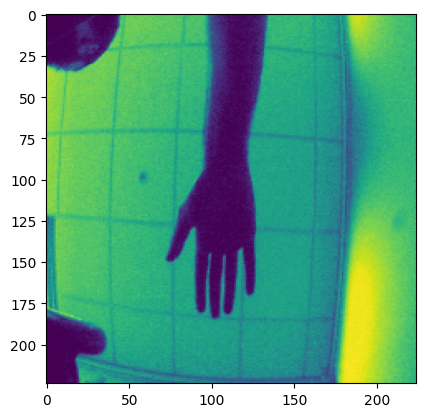

<class 'torch.Tensor'>


In [7]:
vis_dataset()

### Attention

In [ ]:
import torch
import torch.nn as nn
import numpy as np

def position_embedding(input, d_model):
    input = input.view(-1, 1)
    dim = torch.arange(d_model // 2, dtype=torch.float32, device=input.device).view(1, -1)
    sin = torch.sin(input / 10000 ** (2 * dim / d_model))
    cos = torch.cos(input / 10000 ** (2 * dim / d_model))

    out = torch.zeros((input.shape[0], d_model), device=input.device)
    out[:, ::2] = sin
    out[:, 1::2] = cos
    return out

def sinusoid_encoding_table(max_len, d_model):
    pos = torch.arange(max_len, dtype=torch.float32)
    out = position_embedding(pos, d_model)
    return out

class ScaledDotProductAttention(nn.Module):
    """
    Scaled dot-product attention
    """

    def __init__(self, d_model, d_k, d_v, h):
        """
        :param d_model: Output dimensionality of the model
        :param d_k: Dimensionality of queries and keys
        :param d_v: Dimensionality of values
        :param h: Number of heads
        """
        super(ScaledDotProductAttention, self).__init__()
        self.fc_q = nn.Linear(d_model, h * d_k)
        self.fc_k = nn.Linear(d_model, h * d_k)
        self.fc_v = nn.Linear(d_model, h * d_v)
        self.fc_o = nn.Linear(h * d_v, d_model)

        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.h = h

        self.init_weights(gain=1.0)

    def init_weights(self, gain=1.0):
        nn.init.xavier_normal_(self.fc_q.weight, gain=gain)
        nn.init.xavier_normal_(self.fc_k.weight, gain=gain)
        nn.init.xavier_normal_(self.fc_v.weight, gain=gain)
        nn.init.xavier_normal_(self.fc_o.weight, gain=gain)
        nn.init.constant_(self.fc_q.bias, 0)
        nn.init.constant_(self.fc_k.bias, 0)
        nn.init.constant_(self.fc_v.bias, 0)
        nn.init.constant_(self.fc_o.bias, 0)

    def forward(self, queries, keys, values):
        """
        Computes
        :param queries: Queries (b_s, nq, d_model)
        :param keys: Keys (b_s, nk, d_model)
        :param values: Values (b_s, nk, d_model)
        :return:
        """
        b_s, nq = queries.shape[:2]
        nk = keys.shape[1]
        q = self.fc_q(queries).view(b_s, nq, self.h, self.d_k).permute(0, 2, 1, 3)  # (b_s, h, nq, d_k)
        k = self.fc_k(keys).view(b_s, nk, self.h, self.d_k).permute(0, 2, 3, 1)  # (b_s, h, d_k, nk)
        v = self.fc_v(values).view(b_s, nk, self.h, self.d_v).permute(0, 2, 1, 3)  # (b_s, h, nk, d_v)

        att = torch.matmul(q, k) / np.sqrt(self.d_k)  # (b_s, h, nq, nk)

        att = torch.softmax(att, -1)

        out = torch.matmul(att, v).permute(0, 2, 1, 3).contiguous().view(b_s, nq, self.h * self.d_v)  # (b_s, nq, h*d_v)
        out = self.fc_o(out)  # (b_s, nq, d_model)
        return out

class MultiHeadAttention(nn.Module):
    """
    Multi-head attention layer with Dropout and Layer Normalization.
    """

    def __init__(self, d_model, d_k, d_v, h, dff=2048, dropout=.1):
        super(MultiHeadAttention, self).__init__()

        self.attention = ScaledDotProductAttention(d_model=d_model, d_k=d_k, d_v=d_v, h=h)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_norm = nn.LayerNorm(d_model)
        # self.layer_norm2 = nn.LayerNorm(d_model)

        self.fc = nn.Sequential(*[nn.Linear(d_model, dff), nn.ReLU(inplace=True), nn.Dropout(p=dropout),
                                  nn.Linear(dff, d_model)])

    def forward(self, queries, keys, values):
        att = self.attention(queries, keys, values)
        att = self.dropout(att)
        # att = self.layer_norm(queries + att)
        att = self.fc(att)
        att = self.dropout(att)
        return self.layer_norm(queries + att)

class EncoderSelfAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_head, dff=2048, dropout_transformer=.1, n_module=6):
        super(EncoderSelfAttention, self).__init__()
        self.encoder = nn.ModuleList([MultiHeadAttention(d_model, d_k, d_v, n_head, dff, dropout_transformer)
                                      for _ in range(n_module)])
    def forward(self, x):
        in_encoder = x + sinusoid_encoding_table(x.shape[1], x.shape[2]).expand(x.shape).cuda()
        for l in self.encoder:
            in_encoder = l(in_encoder, in_encoder, in_encoder)
        return in_encoder

### Model Building

In [9]:
def build_timm_backbone(model_name=model_name, hyperparams=hyperparams):
    print('build_model args')
    print(f"Creating model: {model_name}")
        
    if 'vit' in model_name or 'deit' in model_name:
        model = timm.create_model(
            model_name,
            pretrained=hyperparams.get('pretrained', False),
            pretrained_cfg=None,
            pretrained_cfg_overlay=None,
            num_classes=0,
            drop_rate=hyperparams.get('dropout2d', 0.0),
            drop_path_rate=hyperparams.get('drop_path', 0.0),
            drop_block_rate=None,
            img_size=hyperparams.get('input_size', 224)
        )
    else:
        try:
            model = timm.create_model(
                model_name,
                pretrained=hyperparams.get('pretrained', False),
                pretrained_cfg=None,
                pretrained_cfg_overlay=None,
                num_classes=0,
                drop_rate=hyperparams.get('dropout2d', 0.0),
                drop_path_rate=hyperparams.get('drop_path', 0.0),
                drop_block_rate=None
            )
        except:
            model = timm.create_model(
                model_name,
                pretrained=hyperparams.get('pretrained', False),
                pretrained_cfg=None,
                pretrained_cfg_overlay=None,
                num_classes=0,
                drop_rate=hyperparams.get('dropout2d', 0.0),
                drop_path_rate=hyperparams.get('drop_path', 0.0),
                drop_block_rate=None
            )

    return model

In [14]:
class _GestureTransformer(nn.Module):
    """Multi Modal model for gesture recognition on 3 channel"""
    def __init__(self, backbone: nn.Module, in_planes: int, out_planes: int,
                 pretrained: bool = False, dropout_backbone=0.1,
                 **kwargs):
        super(_GestureTransformer, self).__init__()
        
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.self_attention = EncoderSelfAttention(512, 64, 64, n_head= 8, dropout_transformer= 0.5, dff= 1024, n_module= 6)
        self.pool = nn.AdaptiveAvgPool2d((1, 512))
        self.classifier = nn.Linear(512, out_planes)
        
        if(backbone=="timm"):
            self.backbone = build_timm_backbone() 
            print("Finish building backbone")
            
    def forward(self, x):
        shape = x.shape

        x = x.view(-1, self.in_planes, x.shape[-2], x.shape[-1])

        x = self.backbone(x)
        x = x.view(shape[0], shape[1] // self.in_planes, -1)

        x = self.self_attention(x)

        x = self.pool(x).squeeze(dim=1)
        x = self.classifier(x)
        return x

In [15]:
def build_model(backbone="timm", in_planes = 3, out_planes=12):
    model = _GestureTransformer(backbone = "timm", in_planes = in_planes, out_planes=out_planes)
    return model

### Model Verification

In [16]:
# Veryfing the layers through the model
from torchinfo import summary


model = build_model(backbone="timm", in_planes=3, out_planes=12)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to device

# AI ASSISTED-> I had an issue with moving model and data to the correct device
train_loader, val_loader, test_loader = build_dataloaders()

test_input = next(iter(train_loader))
# Move input to the same device as model
output = model(test_input[0].to(device))

print("Input shape: ",test_input[0].shape)
print("Output shape", output.shape)

# AI ASSISTED -> I wanted to find a quick way to get intermediate layers, and so I use torchsummary
print("Intermediate shapes: ")
summary(
    model,
    input_size=(1, 93, 224, 224),
    col_names=["input_size", "output_size", "num_params"],
    depth=5
)



build_model args
Creating model: resnet18.a1_in1k
Finish building backbone
Loading Briareo TRAIN dataset... done.
Loading Briareo TEST dataset... done.
Loading Briareo VAL dataset... done.
Input shape:  torch.Size([1, 93, 224, 224])
Output shape torch.Size([1, 12])
Intermediate shapes: 


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
_GestureTransformer                                     [1, 93, 224, 224]         [1, 12]                   --
├─ResNet: 1-1                                           [31, 3, 224, 224]         [31, 512]                 --
│    └─Conv2d: 2-1                                      [31, 3, 224, 224]         [31, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                                 [31, 64, 112, 112]        [31, 64, 112, 112]        128
│    └─ReLU: 2-3                                        [31, 64, 112, 112]        [31, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                                   [31, 64, 112, 112]        [31, 64, 56, 56]          --
│    └─Sequential: 2-5                                  [31, 64, 56, 56]          [31, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                             [31, 64, 56, 56]          [31, 64, 56, 56]     

### Training

In [13]:
import os
import torch
import torch.nn as nn

from pathlib import Path

class ModuleUtilizer(object):
    """Module utility class

    Attributes:
        configer (Configer): Configer object, contains procedure configuration.

    """
    def __init__(self, configer):
        """Class constructor for Module utility"""
        self.configer = configer
        self.device = self.configer.get("device")

        self.save_policy = self.configer.get("checkpoints", "save_policy")
        if self.save_policy in ["early_stop", "earlystop"]:
            self.save = self.early_stop
        elif self.save_policy == "all":
            self.save = self.save_all
        else:
            self.save = self.save_best

        self.best_accuracy = 0
        self.last_improvement = 0

    def update_optimizer(self, net, iters):
        """Load optimizer and adjust learning rate during training, if using SGD.

                Args:
                    net (torch.nn.Module): Module in use
                    iters (int): current iteration number

                Returns:
                    optimizer (torch.optim.optimizer): PyTorch Optimizer
                    lr (float): Learning rate for training procedure

        """
        optim = self.configer.get('solver', 'type')
        decay = self.configer.get('solver', 'weight_decay')

        if optim == "Adam":
            print("Using Adam.")
            lr = self.configer.get('solver', 'base_lr')
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr,
                                         weight_decay=decay)

        elif optim == "AdamW":
            lr = self.configer.get('solver', 'base_lr')
            optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()), lr=lr,
                                          weight_decay=decay)

        elif optim == "RMSProp":
            lr = self.configer.get('solver', 'base_lr')
            optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, net.parameters()), lr=lr,
                                            weight_decay=decay)

        elif optim == "SGD":
            print("Using SGD")
            policy = self.configer.get('solver', 'lr_policy')

            if policy == 'fixed':
                lr = self.configer.get('solver', 'base_lr')

            elif policy == 'step':
                gamma = self.configer.get('solver', 'gamma')
                ratio = gamma ** (iters // self.configer.get('solver', 'step_size'))
                lr = self.configer.get('solver', 'base_lr') * ratio

            elif policy == 'exp':
                lr = self.configer.get('solver', 'base_lr') * (self.configer.get('solver', 'gamma') ** iters)

            elif policy == 'inv':
                power = -self.configer.get('solver', 'power')
                ratio = (1 + self.configer.get('solver', 'gamma') * iters) ** power
                lr = self.configer.get('solver', 'base_lr') * ratio

            elif policy == 'multistep':
                lr = self.configer.get('solver', 'base_lr')
                for step_value in self.configer.get('solver', 'stepvalue'):
                    if iters >= step_value:
                        lr *= self.configer.get('solver', 'gamma')
                    else:
                        break
            else:
                raise NotImplementedError('Policy:{} is not valid.'.format(policy))

            optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr = lr,
                                        momentum=self.configer.get('solver', 'momentum'), weight_decay=decay)

        else:
            raise NotImplementedError('Optimizer: {} is not valid.'.format(optim))

        return optimizer, lr

    def load_net(self, net):
        """Loading net method. If resume is True load from provided checkpoint, if False load new DataParallel

                Args:
                    net (torch.nn.Module): Module in use

                Returns:
                    net (torch.nn.DataParallel): Loaded Network module
                    iters (int): Loaded current iteration number, 0 if Resume is False
                    epoch (int): Loaded current epoch number, 0 if Resume is False
                    optimizer (torch.nn.optimizer): Loaded optimizer state, None if Resume is False

        """
        iters = 0
        epoch = 0
        optimizer = None
        if self.configer.get('resume') is not None:
            print('Restoring checkpoint: ', self.configer.get('resume'))
            checkpoint_dict = torch.load(self.configer.get('resume'))
            # Remove "module." from DataParallel, if present
            checkpoint_dict['state_dict'] = {k[len('module.'):] if k.startswith('module.') else k: v for k, v in
                                             checkpoint_dict['state_dict'].items()}
            net.load_state_dict(checkpoint_dict['state_dict'])
            iters = checkpoint_dict['iter'] if 'iter' in checkpoint_dict else 0
            optimizer = checkpoint_dict['optimizer'] if 'optimizer' in checkpoint_dict else None
            epoch = checkpoint_dict['epoch'] if 'epoch' in checkpoint_dict else None
        net = nn.DataParallel(net, device_ids=self.configer.get('gpu')).to(self.device)
        return net, iters, epoch, optimizer

    def _save_net(self, net, optimizer, iters, epoch, all=False):
        """Saving net state method.

                Args:
                    net (torch.nn.Module): Module in use
                    optimizer (torch.nn.optimizer): Optimizer state to save
                    iters (int): Current iteration number to save
                    epoch (int): Current epoch number to save

        """
        state = {
            'iter': iters,
            'epoch': epoch,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        checkpoints_dir = str(Path(self.configer.get('checkpoints', 'save_dir')) / self.configer.get("dataset"))
        if not os.path.exists(checkpoints_dir):
            os.makedirs(checkpoints_dir)
        if all:
            latest_name = '{}_{}.pth'.format(self.configer.get('checkpoints', 'save_name'), epoch)
        else:
            latest_name = 'best_{}.pth'.format(self.configer.get('checkpoints', 'save_name'))
        torch.save(state, os.path.join(checkpoints_dir, latest_name))

    def save_all(self, accuracy, net, optimizer, iters, epoch):
        self._save_net(net, optimizer, iters, epoch, all=True)
        return accuracy

    def save_best(self, accuracy, net, optimizer, iters, epoch):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self._save_net(net, optimizer, iters, epoch)
            return self.best_accuracy
        else:
            return 0

    def early_stop(self, accuracy, net, optimizer, iters, epoch):
        ret = self.save_best(accuracy, net, optimizer, iters, epoch)
        if ret > 0:
            self.last_improvement = 0
        else:
            self.last_improvement += 1
        if self.last_improvement >= self.configer.get("checkpoints", "early_stop"):
            return -1
        else:
            return ret

In [14]:
def update_metrics(self, split: str, loss, bs, accuracy=None):
    self.losses[split].update(loss, bs)
    if accuracy is not None:
        self.accuracy[split].update(accuracy, bs)
    if split == "train" and self.iters % self.save_iters == 0:
        self.tbx_summary.add_scalar('{}_loss'.format(split), self.losses[split].avg, self.iters)
        self.tbx_summary.add_scalar('{}_accuracy'.format(split), self.accuracy[split].avg, self.iters)
        self.losses[split].reset()
        self.accuracy[split].reset()

In [15]:
def device(self):
    return next(self.parameters()).device

In [16]:
def train_model(num_epochs=10):
    """Simple training script"""
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    print("\n=== Loading Data ===")
    train_loader, test_loader, val_loader = data_loader()
    
    # Build model
    print("\n=== Building Model ===")
    model = build_model(backbone="timm", in_planes=3, out_planes=12)
    model = model.to(device)
    
    # Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
    scheduler = MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)
    
    best_val_acc = 0.0
    
    # Training loop
    print("\n=== Starting Training ===")
    for epoch in range(1, num_epochs + 1):
        print(f"\n--- Epoch {epoch}/{num_epochs} ---")
        
        # TRAIN
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in tqdm(train_loader, desc="Train"):
            inputs = inputs.to(device)
            labels = labels.to(device).squeeze(1)
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            
            # Metrics
            train_loss += loss.item() * inputs.size(0)
            predicted = torch.argmax(outputs, dim=1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
        
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        
        # VALIDATION
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Val"):
                inputs = inputs.to(device)
                labels = labels.to(device).squeeze(1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                predicted = torch.argmax(outputs, dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"✓ Saved best model!")
        
        # Update learning rate
        scheduler.step()
    
    print(f"\n=== Training Complete ===")
    print(f"Best Val Acc: {best_val_acc:.4f}")
    return model

### Main

In [17]:
def main():
    train_model()


In [18]:
if __name__ == '__main__':
    main()
    


Using device: cuda

=== Loading Data ===


NameError: name 'data_loader' is not defined

In [ ]:
   !nvidia-smi

Fri Jan 23 23:10:04 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.65                 Driver Version: 576.65         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   66C    P4             18W /   45W |    1786MiB /   8151MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch, os, sys

print("Python exe:", sys.executable)
print("Torch file:", torch.__file__)
print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0))
print("Capability:", torch.cuda.get_device_capability(0))
print("CUDA available:", torch.cuda.is_available())


Python exe: c:\Users\USER\miniconda3\envs\revisedTransformer\python.exe
Torch file: c:\Users\USER\miniconda3\envs\revisedTransformer\lib\site-packages\torch\__init__.py
Torch version: 2.10.0+cu128
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 5060 Laptop GPU
Capability: (12, 0)
CUDA available: True
